Setup

In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import optuna
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

c:\Users\fiqih\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

Importing Data

In [4]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels


In [5]:
# Setting up file paths for training and testing
train_dir = r"brain_tumor\Training"
test_dir = r"brain_tumor\Testing"
val_dir = r"brain_tumor\Validation"

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)
val_paths, val_labels = get_data_labels(val_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')
print('\nValidation')
print(f'Number of Paths: {len(val_paths)}')
print(f'Number of Labels: {len(val_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 729
Number of Labels: 729

Validation
Number of Paths: 582
Number of Labels: 582


Data Visualization

Training Counts
{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}

Validation Counts
{'pituitary': 156, 'notumor': 210, 'meningioma': 162, 'glioma': 54}

Testing Counts
{'pituitary': 144, 'notumor': 195, 'meningioma': 144, 'glioma': 246}


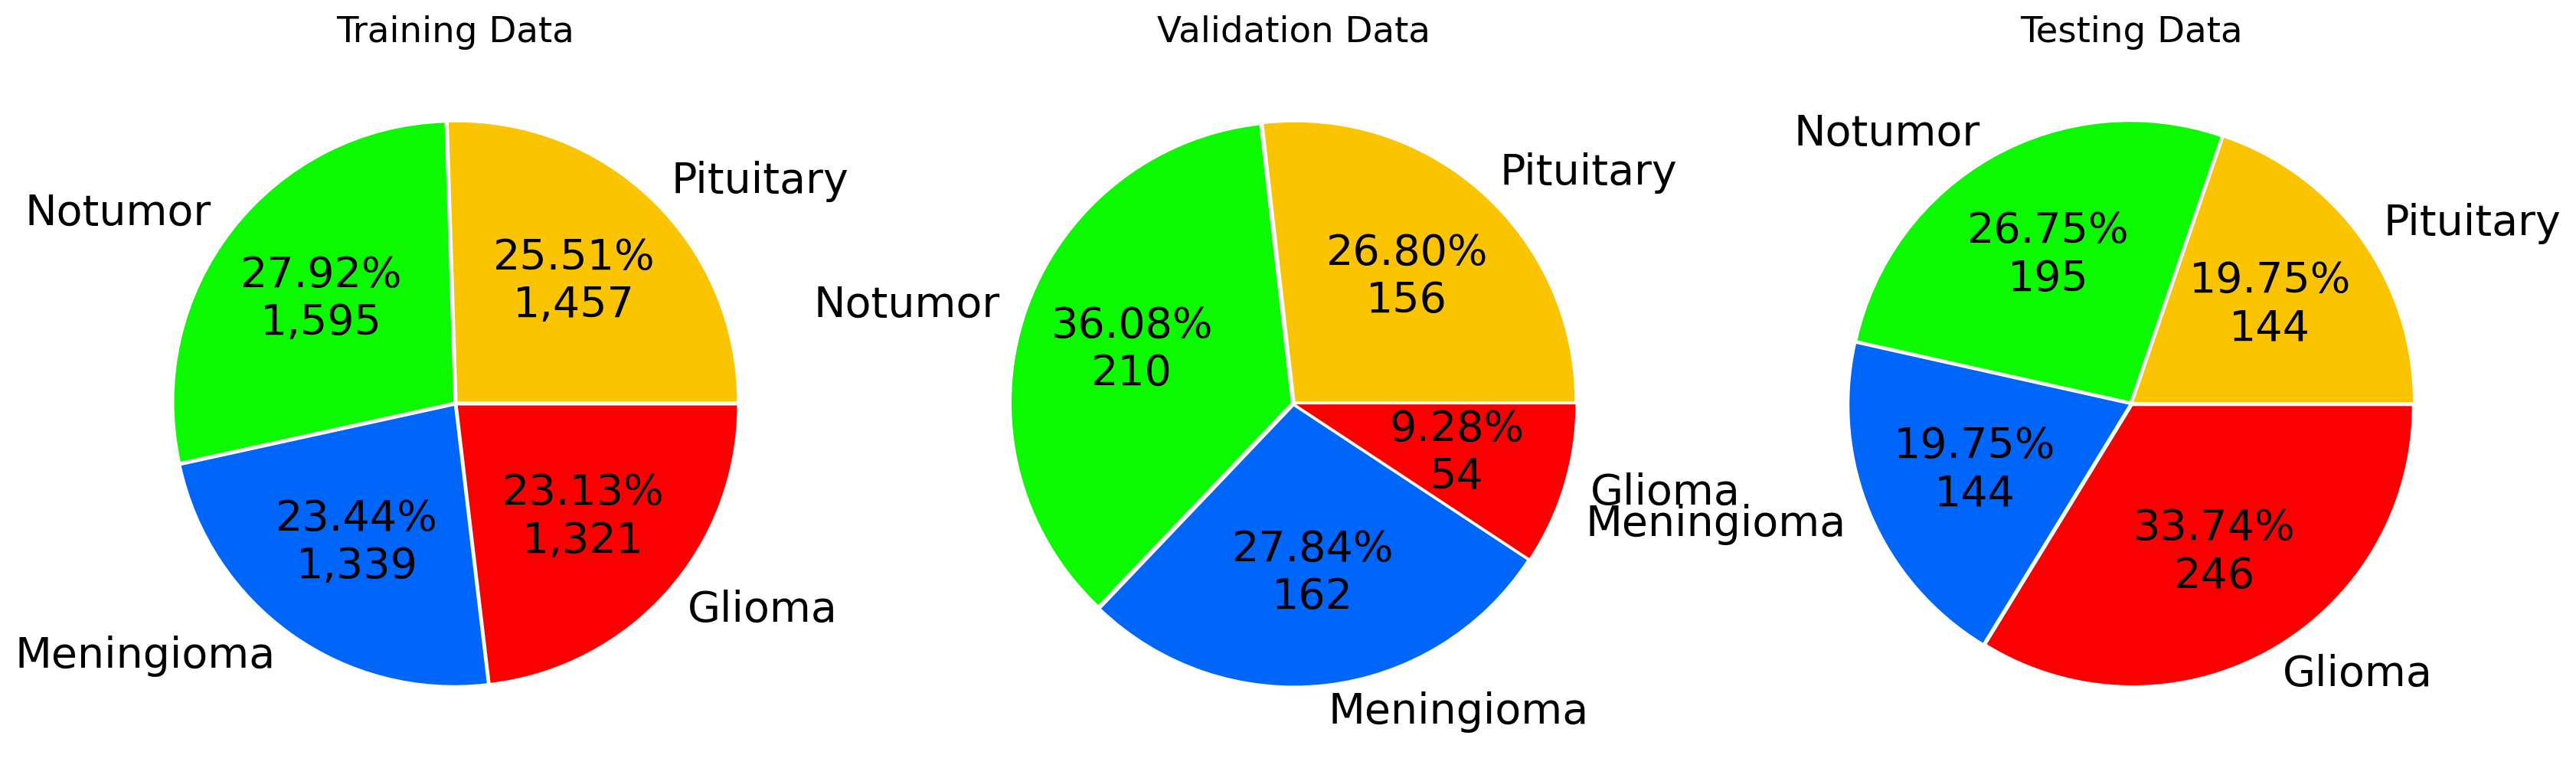

In [6]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts_train = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts_train)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts_train,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts_train) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting validation data types
class_counts_val = [len([x for x in val_labels if x == label]) for label in CLASS_TYPES]
print('\nValidation Counts')
print(dict(zip(CLASS_TYPES, class_counts_val)))

ax[1].set_title('Validation Data')
ax[1].pie(
    class_counts_val,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts_val) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts_test = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts_test)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts_test,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts_test) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)


plt.show()

([<matplotlib.patches.Wedge at 0x235c278d9f0>,
 [Text(0.3190263566790356, -1.0840305271273964, 'Train'),
  Text(0.04426286392835903, 1.1091171258604116, 'Validation'),
  Text(-0.5769255255155656, 0.9482915891267774, 'Test')],
 [Text(0.1778642519537986, -0.6043710018497873, '81.33%\n5,712'),
  Text(0.02432463693360271, 0.60951481691428, '8.29%\n582'),
  Text(-0.31704916267071614, 0.5211332156462469, '10.38%\n729')])

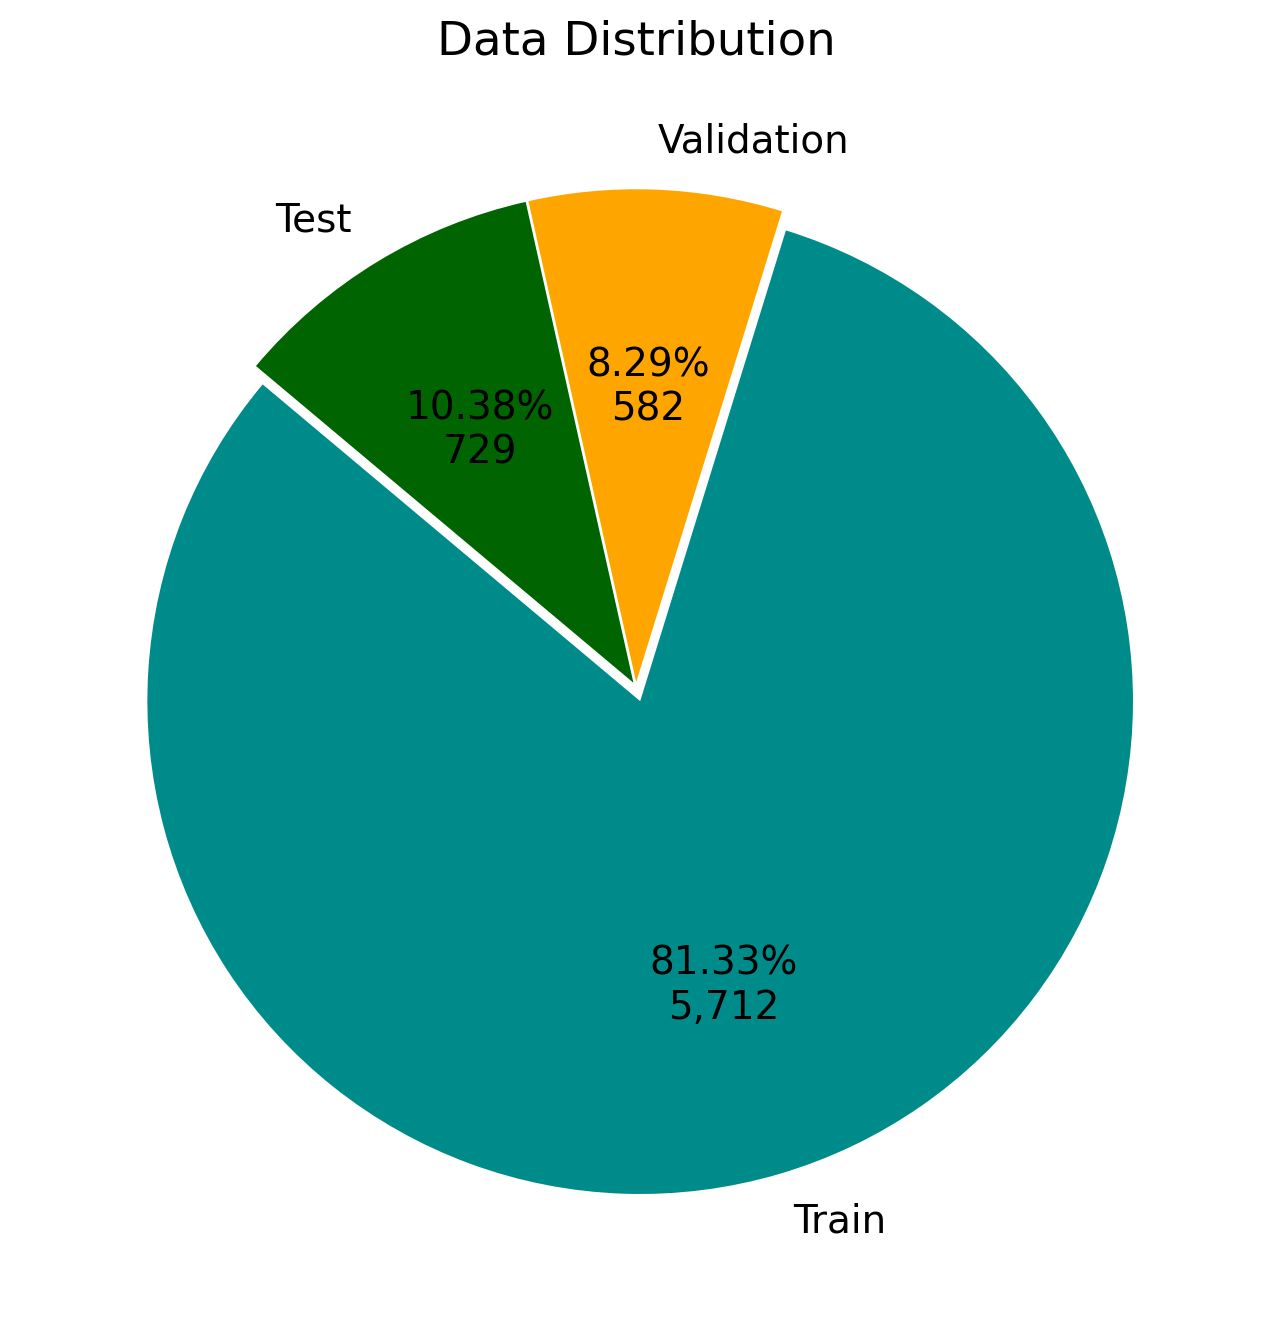

In [7]:
_, ax = plt.subplots(ncols=1, figsize=(10, 8))

# Plotting the combined pie chart
ax.set_title('Data Distribution')
ax.pie(
    [len(train_labels), len(val_labels), len(test_labels)],
    labels=['Train', 'Validation', 'Test'],
    colors=['darkcyan', 'orange', 'darkgreen'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(val_labels), len(test_labels)]) / 100),
    explode=(0.03, 0.01, 0.01),
    textprops={'fontsize': 14},
    startangle=140
)

x reshaped: (1, 150, 150, 3)


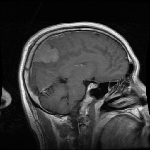

In [8]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [9]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

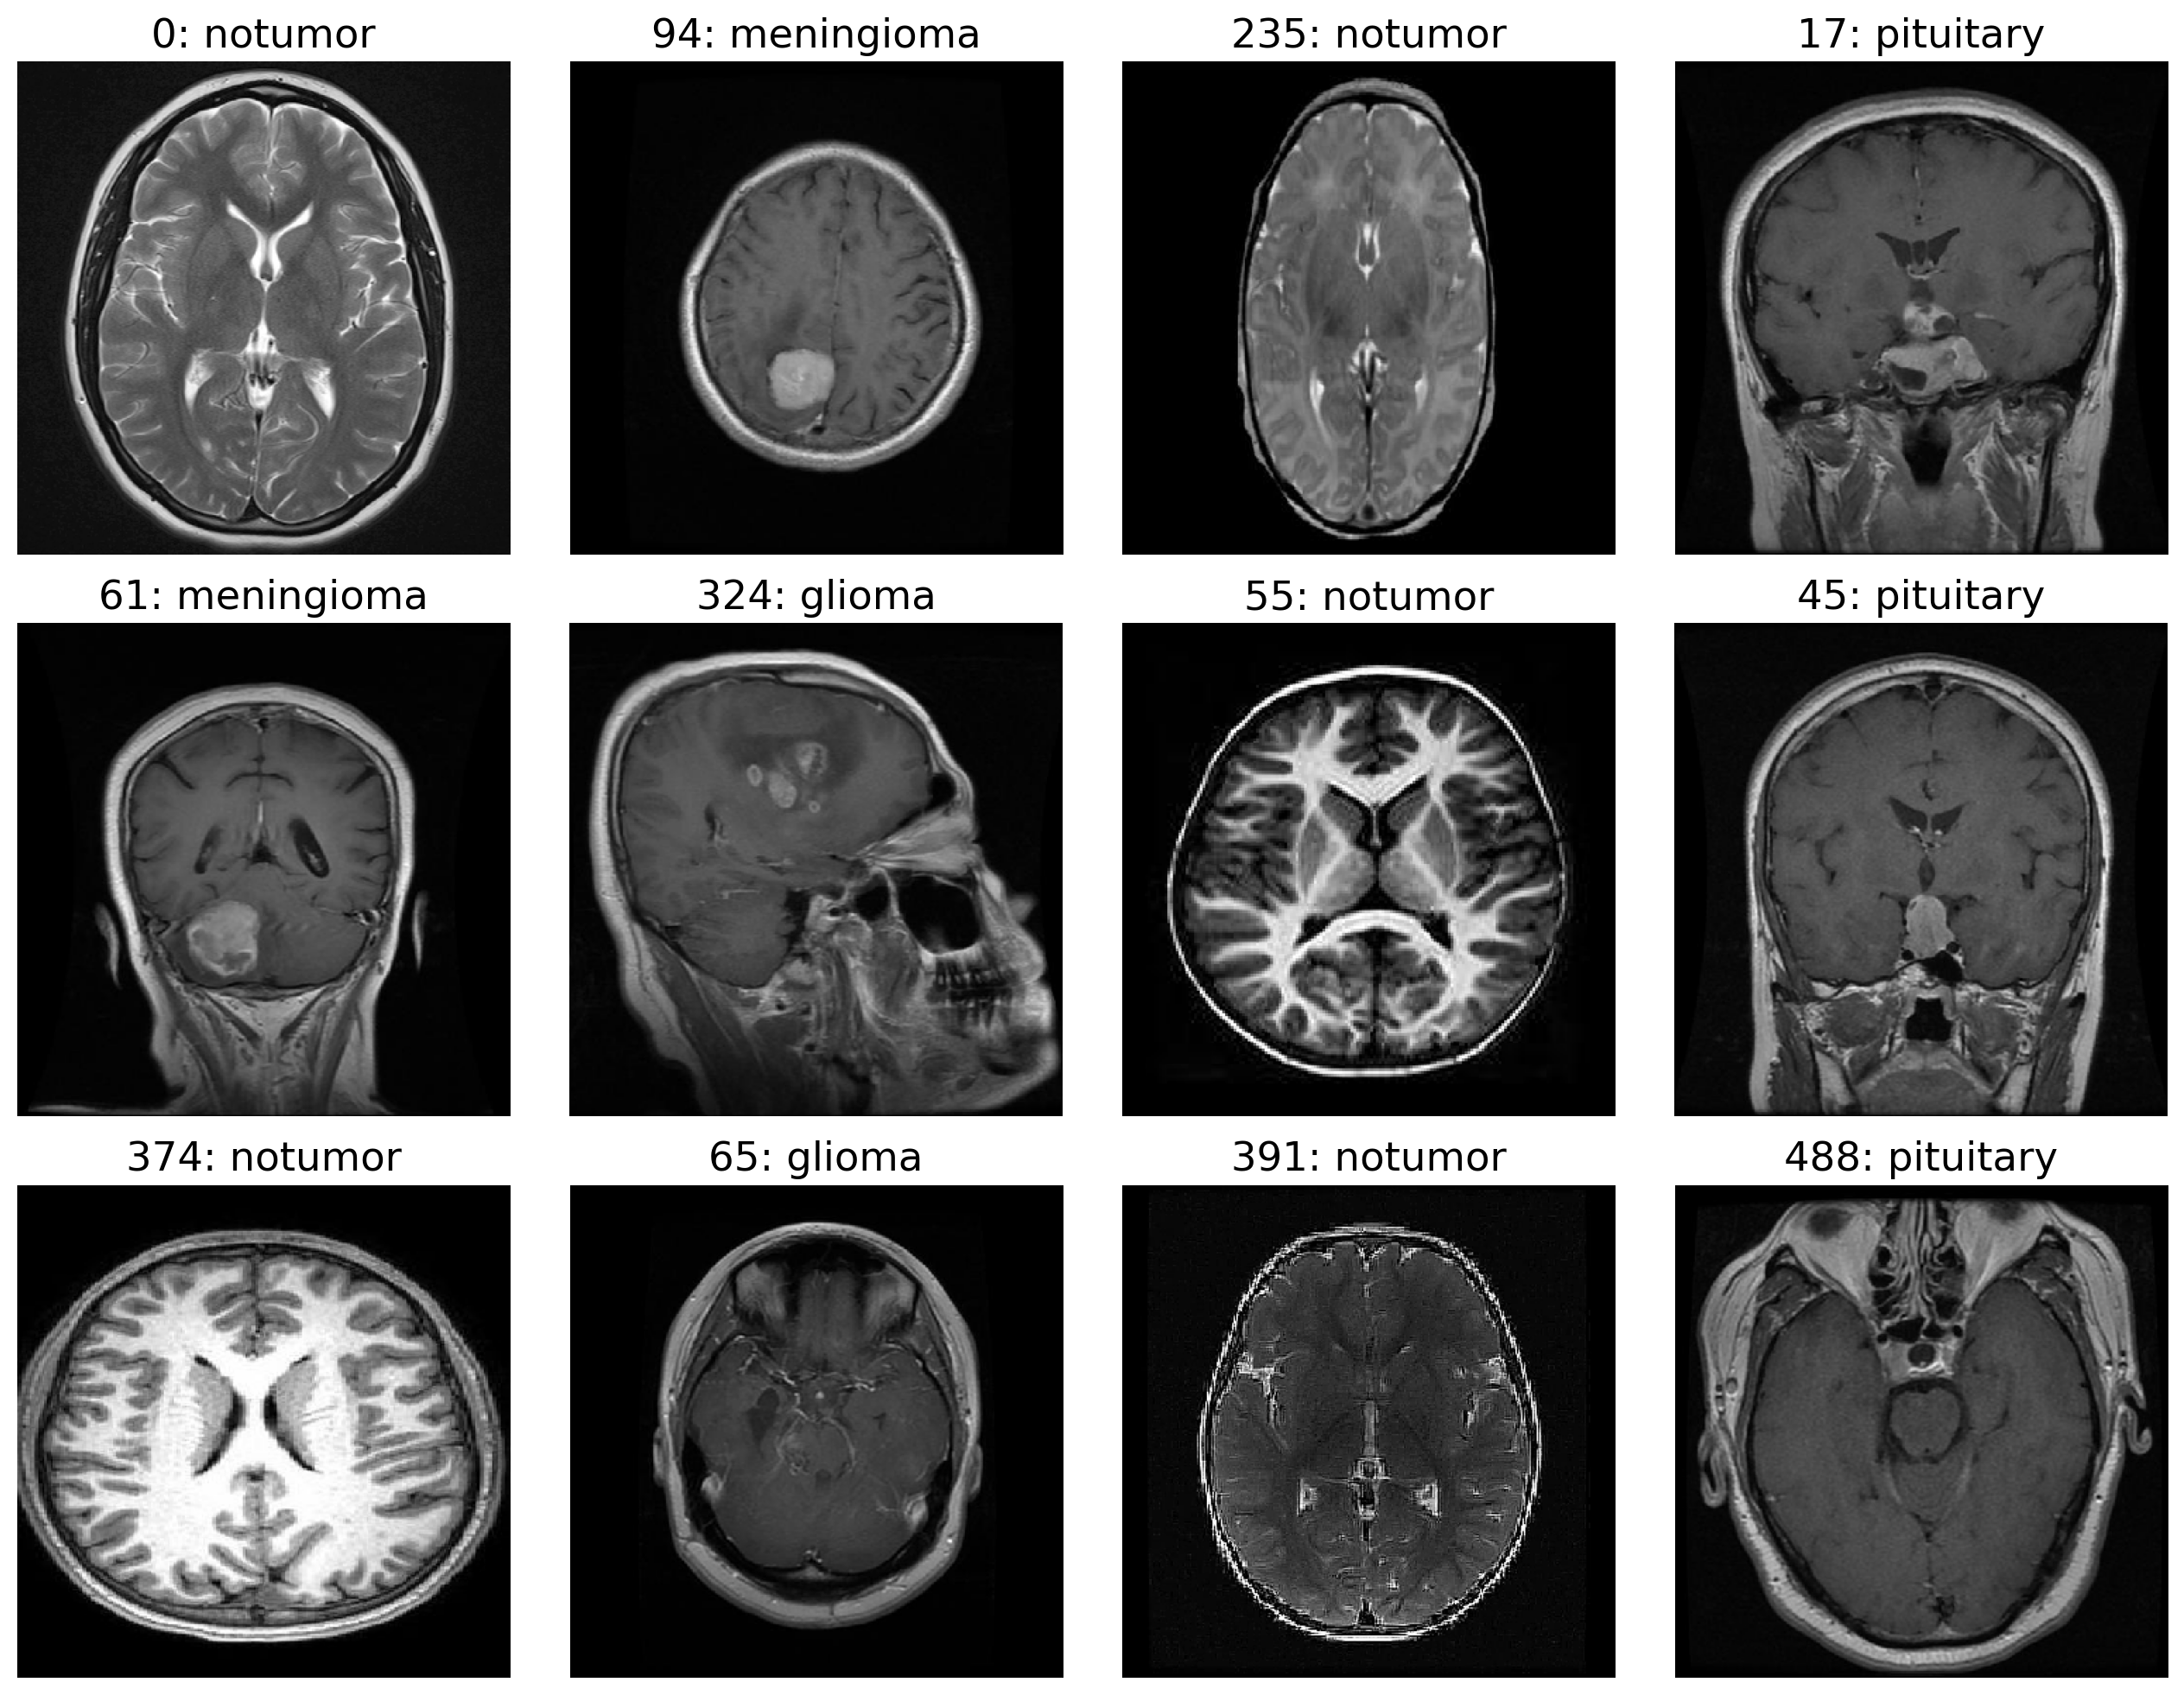

In [10]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

Data Augmentation and Preprocessing

In [11]:
# Image size
img_height, img_width = 150, 150

# Training batch size
batch_size = 32

In [12]:
# No augmentation of the train data, just rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                shuffle=False,
                                                seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 582 images belonging to 4 classes.
Found 729 images belonging to 4 classes.


In [13]:
# Calculate steps per epoch
train_steps_per_epoch = max(1, train_generator.samples // batch_size)
val_steps_per_epoch = max(1, val_generator.samples // batch_size)

In [14]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Training Setup Values

In [15]:
def create_model(trial):
    model = models.Sequential()
    
    # Convolutional layer 1
    model.add(Conv2D(trial.suggest_int('conv1_filters', 16, 64), (4, 4), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    # Convolutional layer 2
    model.add(Conv2D(trial.suggest_int('conv2_filters', 32, 128), (4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Convolutional layer 3
    model.add(Conv2D(trial.suggest_int('conv3_filters', 64, 128), (4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Convolutional layer 4
    model.add(Conv2D(trial.suggest_int('conv4_filters', 64, 128), (4, 4), activation='relu'))
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(trial.suggest_int('dense_units', 256, 1024), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5), seed=SEED))
    model.add(Dense(N_TYPES, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Training Model

In [16]:
def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_generator,
        validation_steps=val_steps_per_epoch,
        epochs=5,  # You can increase this number for better results
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, 'val_accuracy')]
    )
    
    val_loss, val_accuracy = model.evaluate(val_generator, steps=val_steps_per_epoch, verbose=0)
    return val_accuracy

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)  # You can increase the number of trials for better results

[I 2024-06-26 22:24:32,769] A new study created in memory with name: no-name-c465cdd6-002e-4122-91bb-39a69e8da247
c:\Users\fiqih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\fiqih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\fiqih\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input r

In [17]:
best_trial = study.best_trial
print("Best trial parameters:", best_trial.params)

best_model = create_model(best_trial)
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=40,  # Train the best model for more epochs
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)]
)


Best trial parameters: {'conv1_filters': 18, 'conv2_filters': 119, 'conv3_filters': 116, 'conv4_filters': 123, 'dense_units': 340, 'dropout_rate': 0.2625214457130703, 'learning_rate': 0.0007466599883210347}
Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 57s 302ms/step - accuracy: 0.4981 - loss: 1.0236 - val_accuracy: 0.8403 - val_loss: 0.4256 - learning_rate: 7.4666e-04
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.9375 - loss: 0.3009 - val_accuracy: 0.8333 - val_loss: 0.4128 - learning_rate: 7.4666e-04
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.8299 - loss: 0.4404 - val_accuracy: 0.8681 - val_loss: 0.3091 - learning_rate: 7.4666e-04
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - accuracy: 0.8750 - loss: 0.3657 - val_accuracy: 1.0000 - val_loss: 0.1647 - learning_rate: 7.4666e-04
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.8933 - loss: 0.3091 - val_accuracy: 0.8993 - val_loss: 0.2701 - learning_rate: 7.4666e-04


In [18]:
# Custom callbacks to log metrics
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, test_generator, validation_steps):
        super().__init__()
        self.test_generator = test_generator
        self.validation_steps = validation_steps
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        val_predict = np.array([])
        val_targ = np.array([])

        for step in range(self.validation_steps):
            x_val, y_val = next(self.test_generator)
            preds = np.argmax(self.model.predict(x_val), axis=-1)
            val_predict = np.append(val_predict, preds)
            val_targ = np.append(val_targ, np.argmax(y_val, axis=1))
        
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        
        logs['val_precision'] = _val_precision
        logs['val_recall'] = _val_recall
        logs['val_f1'] = _val_f1
        
        print(f"Epoch {epoch + 1} - val_precision: {_val_precision:.5f}, val_recall: {_val_recall:.5f}, val_f1: {_val_f1:.5f}")

In [19]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        logs['learning_rate'] = lr
        print(f"Epoch {epoch + 1} - Learning rate: {lr:.6f}")

Model Evaluation

In [20]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=16, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(4, 4, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

    
# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

In [21]:
from sklearn.metrics import classification_report

# Evaluasi model
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss:.5f}")
print(f"Test Accuracy: {accuracy:.5f}")

# Mendapatkan prediksi untuk data uji
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label sebenarnya dari data uji
y_true = test_generator.classes

# Menampilkan classification report
clr = classification_report(y_true, y_pred_classes, target_names=CLASS_TYPES)
print(clr)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9514 - loss: 0.2025
Test Loss: 0.13839
Test Accuracy: 0.96875
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
              precision    recall  f1-score   support

   pituitary       1.00      0.94      0.97       246
     notumor       0.90      0.97      0.93       144
  meningioma       0.99      1.00      0.99       195
      glioma       0.97      0.99      0.98       144

    accuracy                           0.97       729
   macro avg       0.97      0.97      0.97       729
weighted avg       0.97      0.97      0.97       729



In [22]:
# Evaluasi pada data latih
train_score = best_model.evaluate(train_generator, verbose=1)
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)

# Evaluasi pada data validasi
valid_score = best_model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)

# Evaluasi pada data uji
test_score = best_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 1.0000 - loss: 4.5563e-04
Train Loss: 0.0005
Train Accuracy: 100.00%
--------------------
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9747 - loss: 0.0972 
Validation Loss: 0.0765
Validation Accuracy: 97.94%
--------------------
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9523 - loss: 0.1995
Test Loss: 0.1336
Test Accuracy: 96.98%


In [23]:
# Evaluating the model
loss, accuracy = best_model.evaluate(train_generator, steps=train_generator.samples//batch_size)
print(f"Train Loss: {loss:0.5f}")
print(f"Train Accuracy: {accuracy:0.5f}")

loss, accuracy = best_model.evaluate(val_generator, steps=val_generator.samples//batch_size)
print(f"Validation Loss: {loss:0.5f}")
print(f"Validation Accuracy: {accuracy:0.5f}")

loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 1.0000 - loss: 5.1795e-04
Train Loss: 0.00050
Train Accuracy: 1.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9744 - loss: 0.0983
Validation Loss: 0.07728
Validation Accuracy: 0.97917
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9514 - loss: 0.2025
Test Loss: 0.13839
Test Accuracy: 0.96875


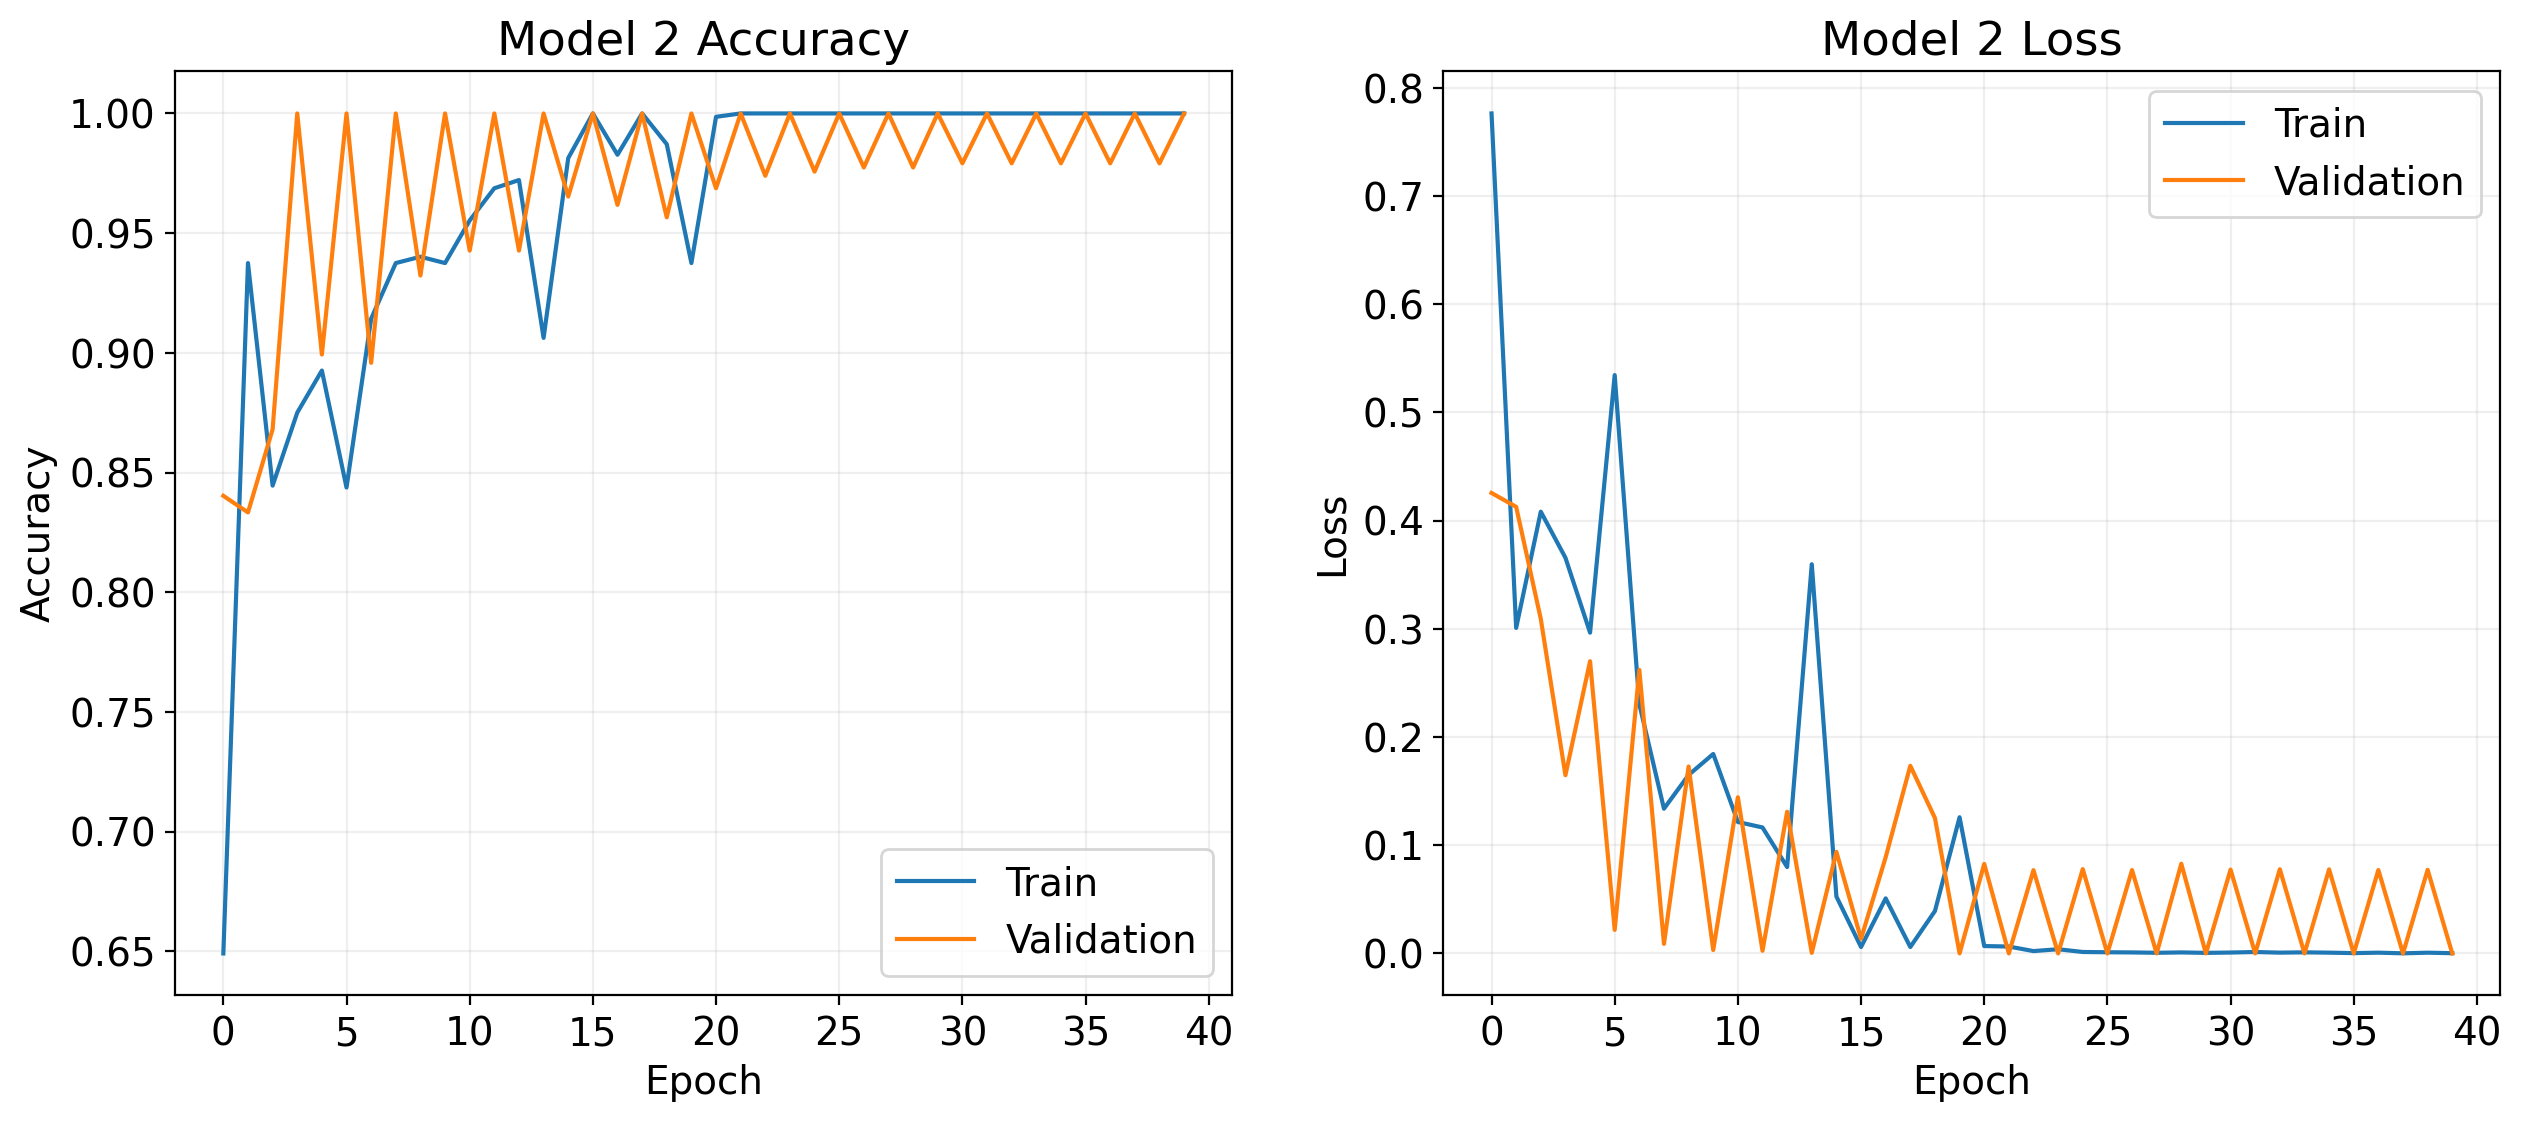

In [25]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


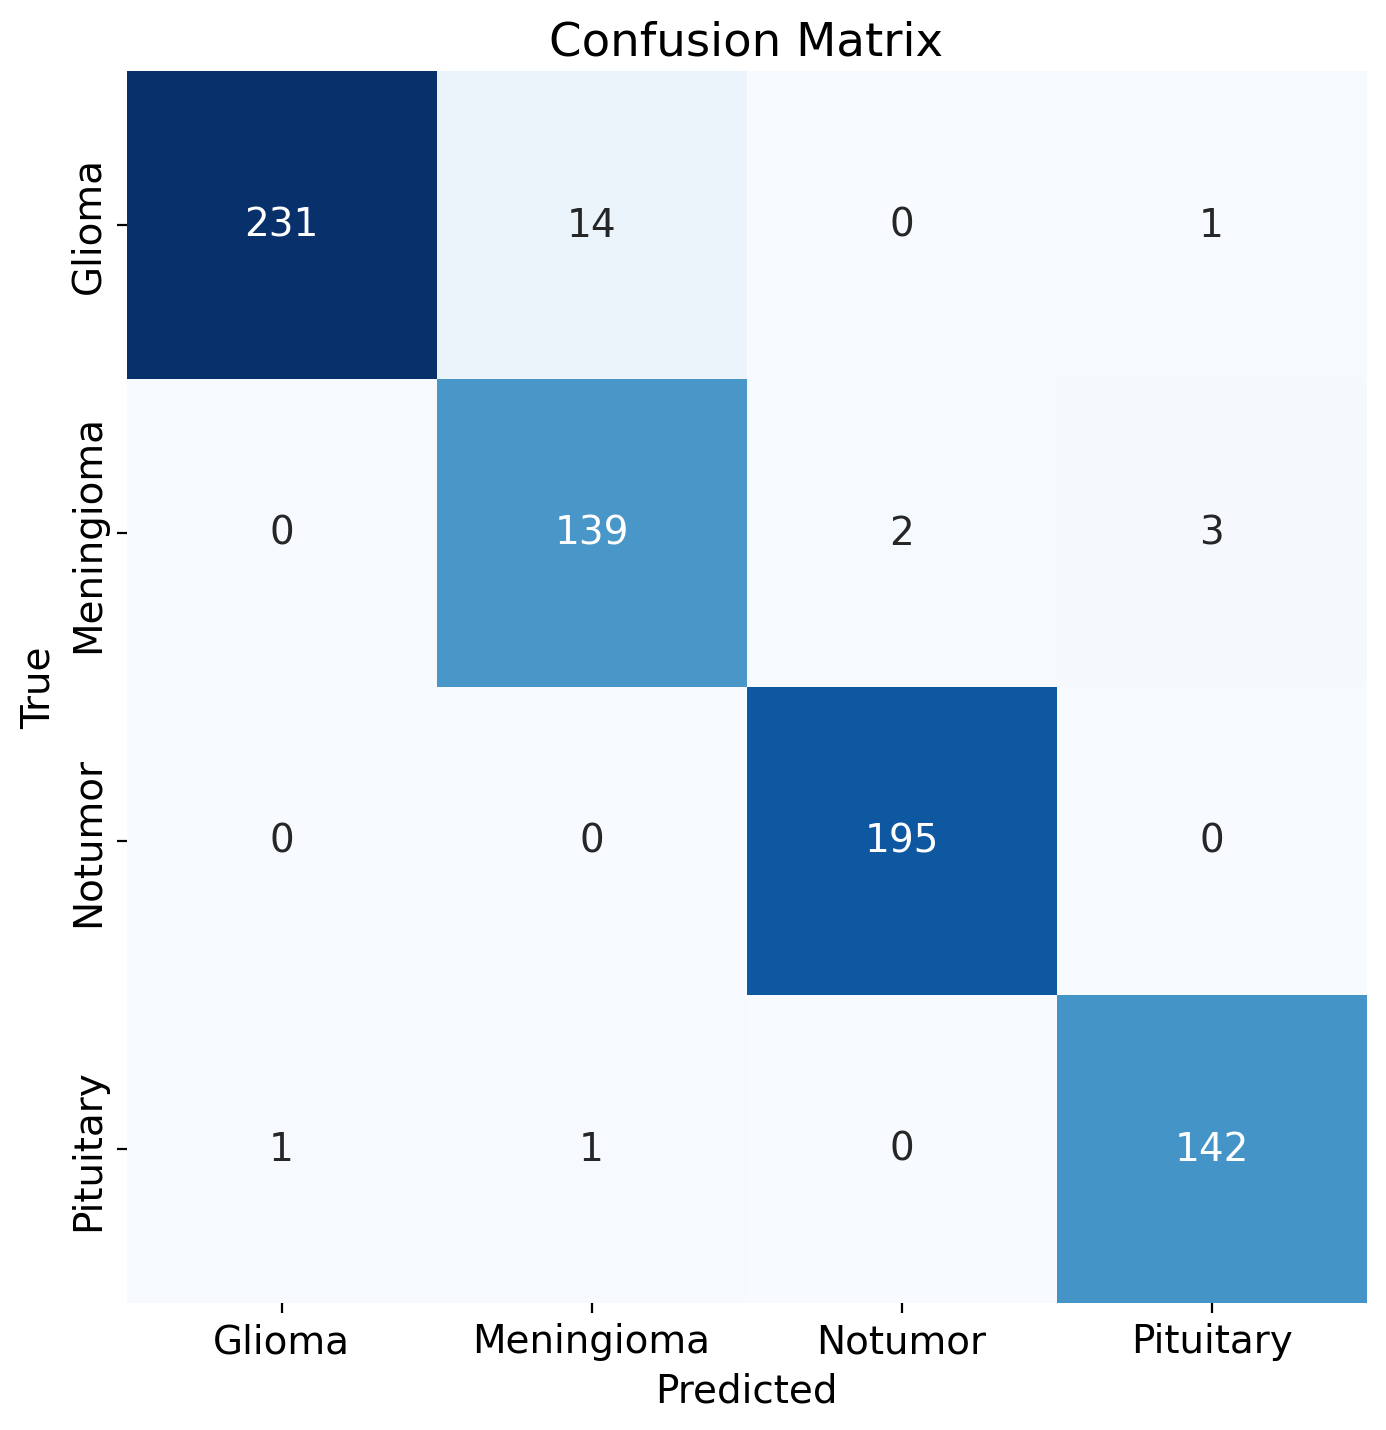

In [26]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=best_model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [27]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

Class: Glioma
Precision: 0.996
Recall: 0.939
F1-Score: 0.967

Class: Meningioma
Precision: 0.903
Recall: 0.965
F1-Score: 0.933

Class: Notumor
Precision: 0.990
Recall: 1.000
F1-Score: 0.995

Class: Pituitary
Precision: 0.973
Recall: 0.986
F1-Score: 0.979


Accuracy: 0.970


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


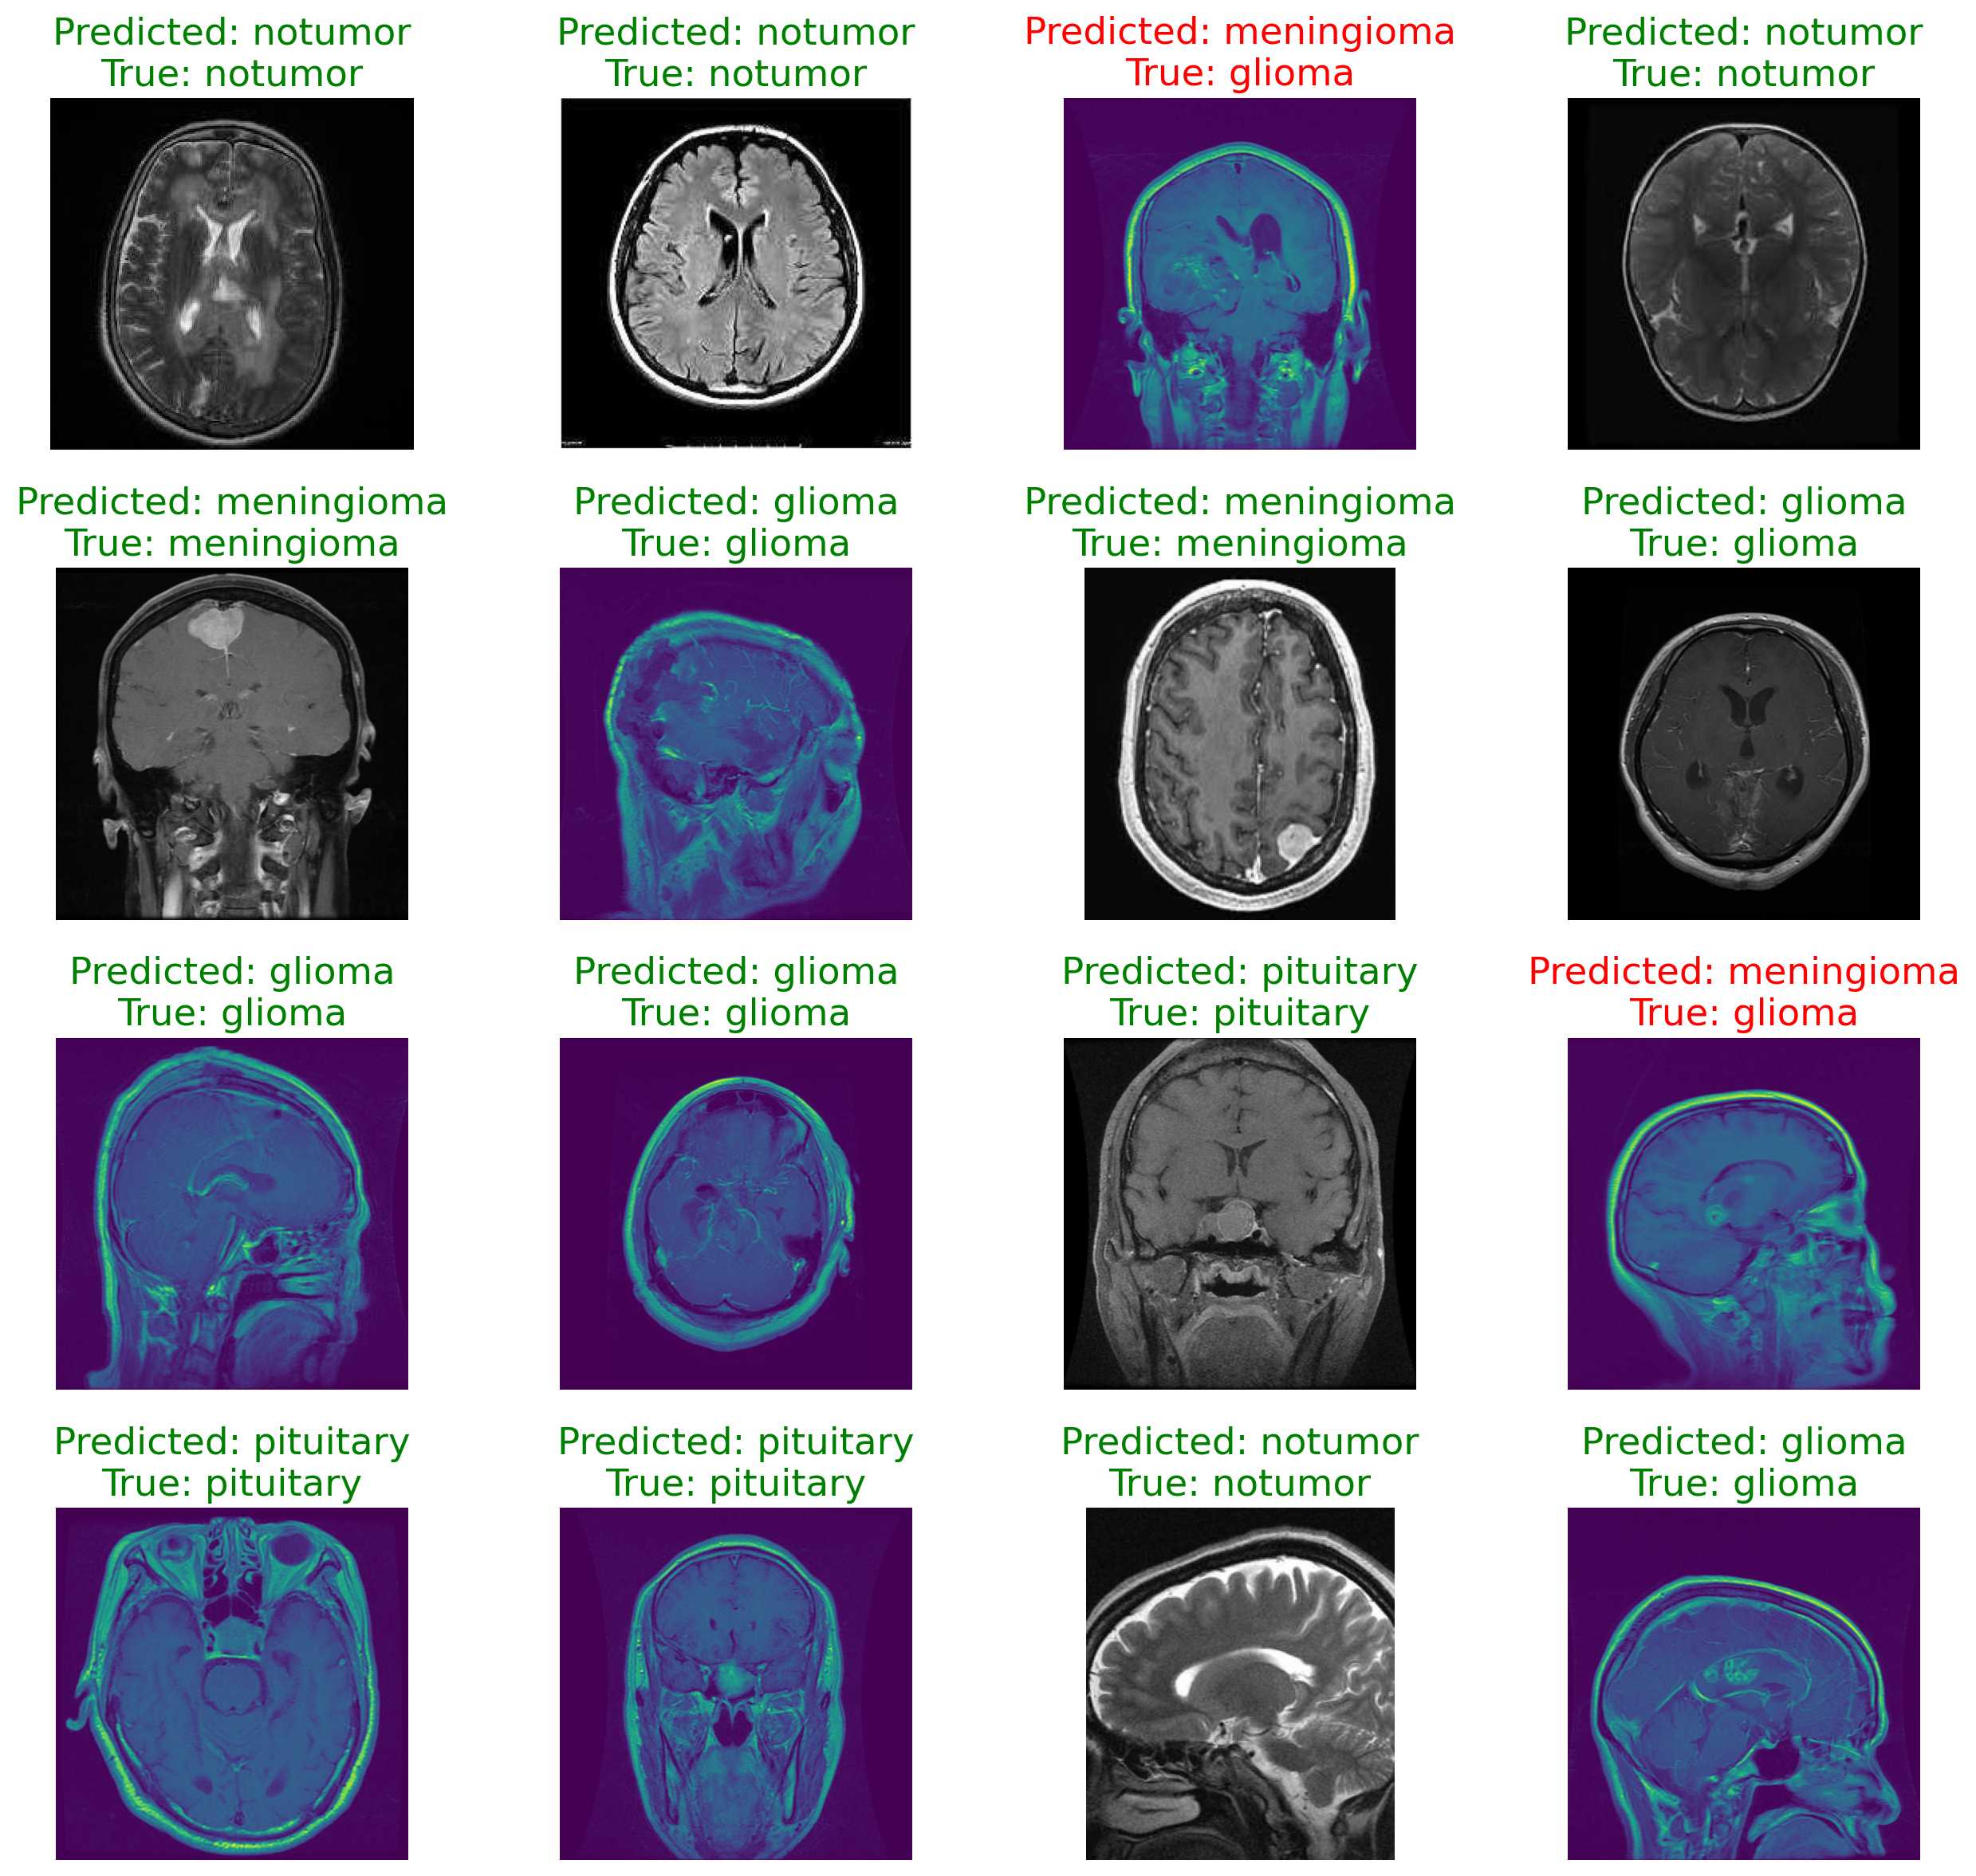

In [28]:
# Using functions in 6.1 for showing results 
plot_sample_predictions(model=best_model, 
                        test_generator=test_generator, 
                        categories=class_indices_train_list,
                        test_dir=test_dir, 
                        num_samples=16,
                        figsize=(13, 12))



In [172]:
import pickle

filename = "model_optuna_non-augmented.pkl"
with open (filename, 'wb') as file:
    pickle.dump(best_model, file)